In [1]:
import fsspec
import xarray as xr
import wandb

import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import TQDMProgressBar

import pyqg_explorer.dataset.forcing_dataset as forcing_dataset
import pyqg_explorer.models.base_model as base_model
import pyqg_explorer.util.pbar as pbar

In [2]:
lev=0
forcing=1

## Wandb config file
config={"lev":lev,
        "forcing":forcing}

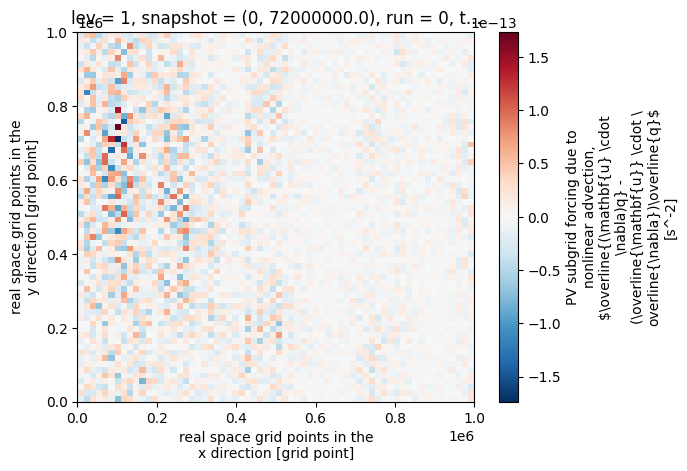

In [3]:
data_full=xr.open_zarr(fsspec.get_mapper(f'/scratch/zanna/data/pyqg/publication/eddy/forcing%s.zarr' % forcing), consolidated=True)
data_forcing=data_full.q_subgrid_forcing.isel(lev=lev)
data_forcing=data_forcing.stack(snapshot=("run","time"))
data_forcing=data_forcing.transpose("snapshot","y","x")
data_forcing.isel(snapshot=20).plot()

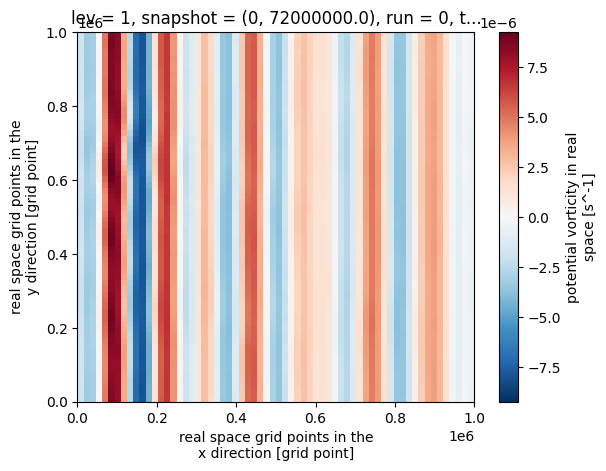

In [4]:
data_q=data_full.q.isel(lev=0)
data_q=data_q.stack(snapshot=("run","time"))
data_q=data_q.transpose("snapshot","y","x")
data_q.isel(snapshot=20).plot()

del data_full

In [5]:
dataset=forcing_dataset.ForcingDataset(data_q,data_forcing,seed=123)

In [6]:
wandb.init(project="pyqg_cnns", entity="chris-pedersen",config=config)
train_loader = DataLoader(
    dataset,
    batch_size=64,
    sampler=SubsetRandomSampler(dataset.train_idx),
)
valid_loader = DataLoader(
    dataset,
    batch_size=64,
    sampler=SubsetRandomSampler(dataset.valid_idx),
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chris-pedersen. Use `wandb login --relogin` to force relogin


In [7]:
#model=base_model.AndrewCNN(1,1,dataset.x_renorm,dataset.y_renorm)
model = base_model.UnetGenerator(1,1,6,x_renorm=torch.tensor(1.), y_renorm=torch.tensor(1.))

In [8]:
logger = WandbLogger()

/ext3/miniconda3/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [ ]:
trainer = pl.Trainer(
    default_root_dir="/scratch/cp3759/pyqg_data/models",
    accelerator="auto",
    max_epochs=150,
    callbacks=pbar.ProgressBar(),
    logger=WandbLogger()
)

trainer.fit(model, train_loader, valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | UnetSkipConnectionBlock | 29.2 M
--------------------------------------------------
29.2 M    Trainable params
0         Non-trainable params
29.2 M    Total params
116.952   Total estimated model params size (MB)
/ext3/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/ext3/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_c

Training:   0%|          | 0/150 [00:00<?, ?it/s]

In [12]:
torch.save(model.state_dict(), '/scratch/cp3759/pyqg_data/models/unet_upper.torch')

In [ ]:
del dataset
del data_full
del data_q
del data_forcing

In [15]:
x_maps=torch.tensor(())
y_true=torch.tensor(())
y_pred=torch.tensor(())

for valid in valid_loader:
    x=valid[0]
    y=valid[1]
    y_hat=model(x)
    ## Concat to form tensors containing all maps
    x_maps=torch.cat((x_maps,x),dim=0)
    y_true=torch.cat((y_true,y),dim=0)
    y_pred=torch.cat((y_pred,y_hat),dim=0)
    
print("done")

done


In [16]:
x_np=x_maps.squeeze().detach().numpy()
y_np=y_true.squeeze().detach().numpy()
y_pred_np=y_pred.squeeze().detach().numpy()

Text(0.5, 1.0, 'True forcing-CNN forcing')

<Figure size 640x480 with 0 Axes>

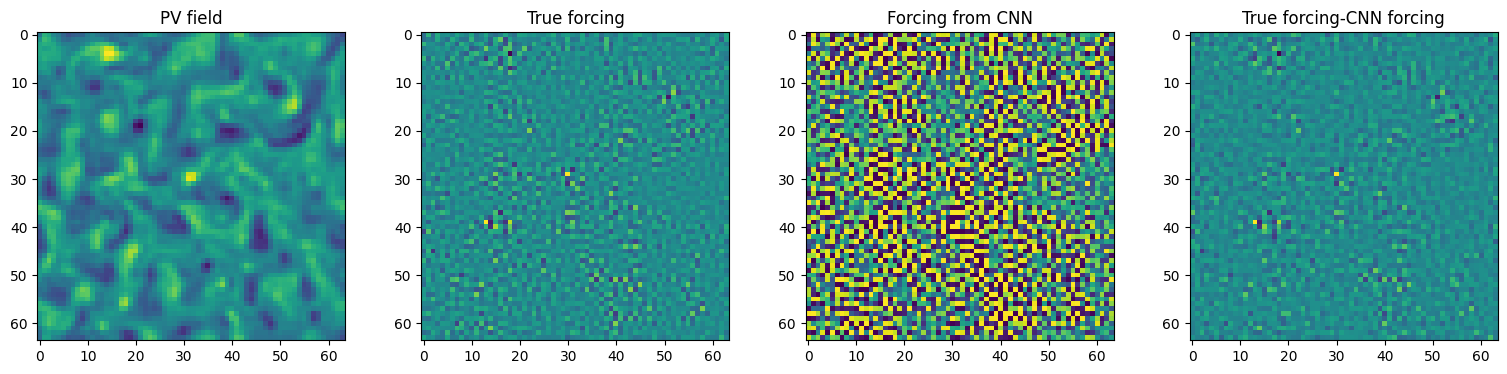

In [20]:
import matplotlib.pyplot as plt
map_index=12
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,4,figsize=(19,4))
axarr[0].imshow(x_np[map_index])
axarr[1].imshow(y_np[map_index])
axarr[2].imshow(y_pred_np[map_index])
axarr[3].imshow(y_np[map_index]-y_pred_np[map_index])

axarr[0].set_title("PV field")
axarr[1].set_title("True forcing")
axarr[2].set_title("Forcing from CNN")
axarr[3].set_title("True forcing-CNN forcing")

In [19]:
from sklearn.metrics import r2_score
r2_score(y_np.flatten(),y_pred_np.flatten())

0.5159159991387022